In [146]:
using PyPlot, LinearAlgebra, Statistics, PyCall
np = pyimport("numpy");

In [143]:
# To be explicit, we use realistic physical values
m_e = 0.5109989461 #(electron mass in MeV / c^2)
hbar = 6.6*10^(-16) # hbar in eV * seconds
c = 3*10^18 # speed of light in angstroms per second
prefac = ((hbar*c)^2/(2*m_e*10^6)) # prefactor of free electron dispersion
a = 5;
bzone_boundary = pi/a;

In [3]:
function Hamiltonian(kx::Float64, ky::Float64, n::Integer, VGs::Matrix{Float64})
    grange = collect(-n:n)
    diagonal_components  = zeros((2n+1)^2)
    idx = 1
    gs = Vector{Vector{Float64}}()
    for i in -n:n
        for j in -n:n
            diagonal_components[idx] = prefac * (kx  .+ 2pi*i/a).^2 + prefac * (ky  .+ 2pi*j/a).^2
            push!(gs, [i, j])
            idx += 1
        end
    end
    H = diagm(diagonal_components)
    g1max, g2max = size(VGs)
    for i in 1:length(diagonal_components)
        row_g = gs[i]
        for g1 in 1:g1max
            for g2 in 1:g2max
                VG = VGs[g1, g2]
                (g1 == 1 && g2 == 1) && continue
                column_g = row_g + [g1-1, g2-1]
                j = findfirst(x->x==column_g, gs)
                !isnothing(j) && (H[i, j] = VG)
                column_g = row_g - [g1-1, g2-1]
                j = findfirst(x->x==column_g, gs)
                !isnothing(j) && (H[i, j] = VG)
            end
        end
    end
    return H
end;

In [303]:
k_y = bzone_boundary;
N = 200
k_xs = range(-bzone_boundary, bzone_boundary, length=N);
V = 0.1
VGs =  prefac * (bzone_boundary)^2 * [0 V; V 0];

In [304]:
hamiltonians = Hamiltonian.(k_xs, k_y, 3, Ref(VGs));
energies_on_boundary = hcat(eigvals.(hamiltonians)...);
analytic_first_band = prefac*k_xs.^2 .+ prefac*k_y^2 .- V * prefac * (bzone_boundary)^2;
analytic_second_band = prefac*k_xs.^2 .+ prefac*k_y^2 .+ V * prefac * (bzone_boundary)^2;

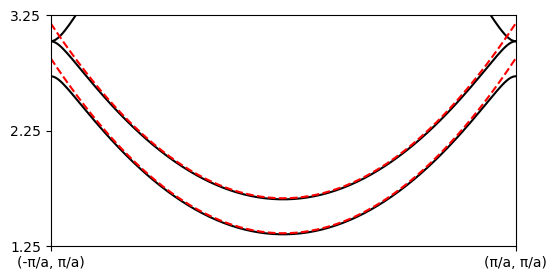

In [305]:
figure(figsize=(6, 3))
plot(transpose(energies_on_boundary)[:, 1:4], color="black")
plot(analytic_first_band, color="red", linestyle="dashed")
plot(analytic_second_band, color="red", linestyle="dashed")

xlim(0, N-1)
ylim(1.25, 3.25)
yticks([1.25, 2.25, 3.25])
xticks([0, N-1], ["(-π/a, π/a)", "(π/a, π/a)"]);

# Finding the Fermi energy for the divalent system

In the case of no perturbation, we know that the Fermi energy for a divalent system will correspond to filling up
a circle with area $\pi k_F^2=(2\pi/a)^2 \rightarrow E_F = \text{prefac} \times k_F^2 = 4 \times \text{prefac} \times \pi/a^2$

In [306]:
prefac * 4 * pi/a^2

1.9281918184971294

In [319]:
N = 1000
ks = range(-bzone_boundary, bzone_boundary, length=N);

In [320]:
V = 0.1
VGs =  prefac * (bzone_boundary)^2 * [0 V; V 0];
hamiltonians = broadcast(Hamiltonian, reshape(ks, (1, N)), reshape(ks, (N, 1)), 1, Ref(VGs));

In [321]:
energies = eigvals.(hamiltonians);

In [357]:
dos, dos_energies = np.histogram(energies, 10000);
dos_normalized = dos * 2 / N^2 / diff(dos_energies)[1];
num_electrons = cumsum(dos_normalized)*diff(dos_energies)[1];

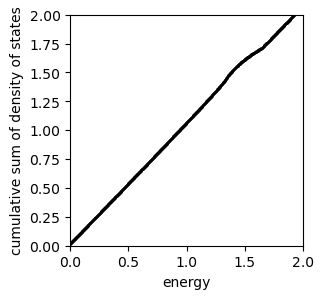

In [367]:
figure(figsize=(3, 3))
scatter(dos_energies[1:end-1], num_electrons, color="black", s=1)
ylabel("cumulative sum of density of states")
xlabel("energy")
xlim(0, 2)
ylim(0, 2);

In [368]:
println("Fermi energy found to be: ", dos_energies[argmin(abs.(num_electrons .- 2))])

Fermi energy found to be: 1.9270770523113117


# Sanity checking Fermi energy with Julia statistics package

In [369]:
numbands = 9
n_electrons = 2
fermi_energy = quantile(vcat(vec(energies)...), n_electrons/(2*numbands));

In [370]:
fermi_energy

1.9292145823377678

In [371]:
k_y = bzone_boundary;
N = 200
k_xs = range(-bzone_boundary, bzone_boundary, length=N);
V = 0.1
VGs =  prefac * (bzone_boundary)^2 * [0 V; V 0];

In [372]:
hamiltonians = Hamiltonian.(k_xs, k_y, 3, Ref(VGs));
energies_on_boundary = hcat(eigvals.(hamiltonians)...);
analytic_first_band = prefac*k_xs.^2 .+ prefac*k_y^2 .- V * prefac * (bzone_boundary)^2;
analytic_second_band = prefac*k_xs.^2 .+ prefac*k_y^2 .+ V * prefac * (bzone_boundary)^2;

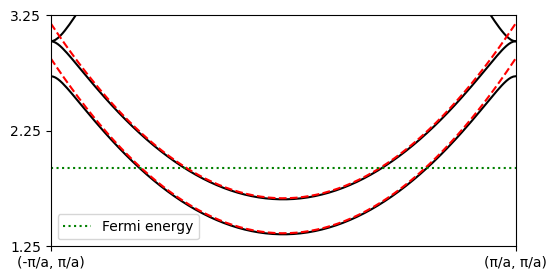

In [373]:
figure(figsize=(6, 3))
plot(transpose(energies_on_boundary)[:, 1:4], color="black")
plot(analytic_first_band, color="red", linestyle="dashed")
plot(analytic_second_band, color="red", linestyle="dashed")
hlines([fermi_energy], 0, N-1, color="green", linestyle="dotted", label="Fermi energy")
legend()
xlim(0, N-1)
ylim(1.25, 3.25)
yticks([1.25, 2.25, 3.25])
xticks([0, N-1], ["(-π/a, π/a)", "(π/a, π/a)"]);